In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb

from PIL import Image
from numpy.linalg import norm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

from img_utils import get_pixels, find_center_of_img, plot_img, find_largest_circle
from img_utils import plot_circle_on_img, find_edge_of_img, plot_edge_of_img
from img_utils import get_dists, smooth_dists, plot_dists, difference, correlation

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# img = Image.open("LP_data/frame_1.png")
# pixels = get_pixels(img)
# plot_img(pixels)
# plt.show()

# pixels = get_pixels(img)
# plot_circle_on_img(pixels)
# plt.show()

# pixels = get_pixels(img)
# plot_edge_of_img(pixels)
#plt.show()

Processing frame_1.png
Processing frame_2.png
Processing frame_3.png
Processing frame_4.png
Processing frame_5.png
Processing frame_6.png
Processing frame_7.png
Processing frame_8.png
Processing frame_9.png
Processing frame_10.png


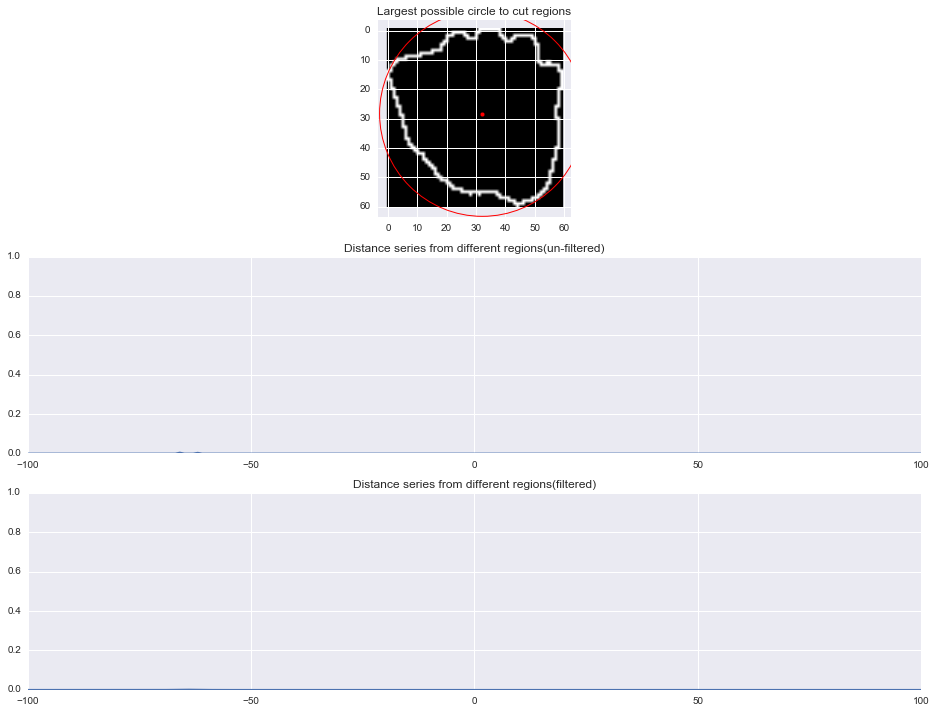

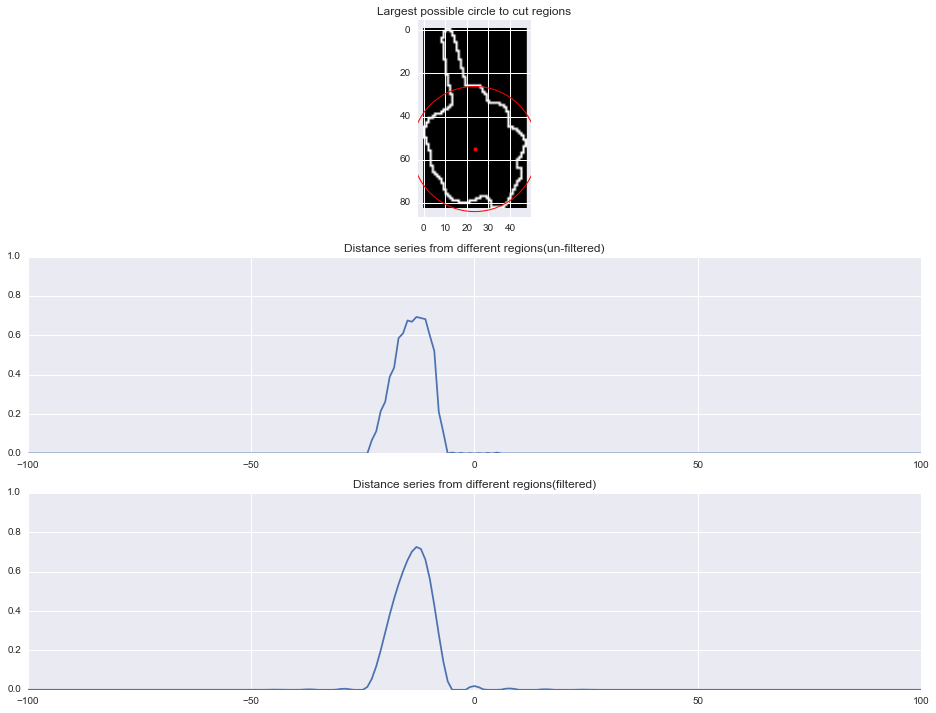

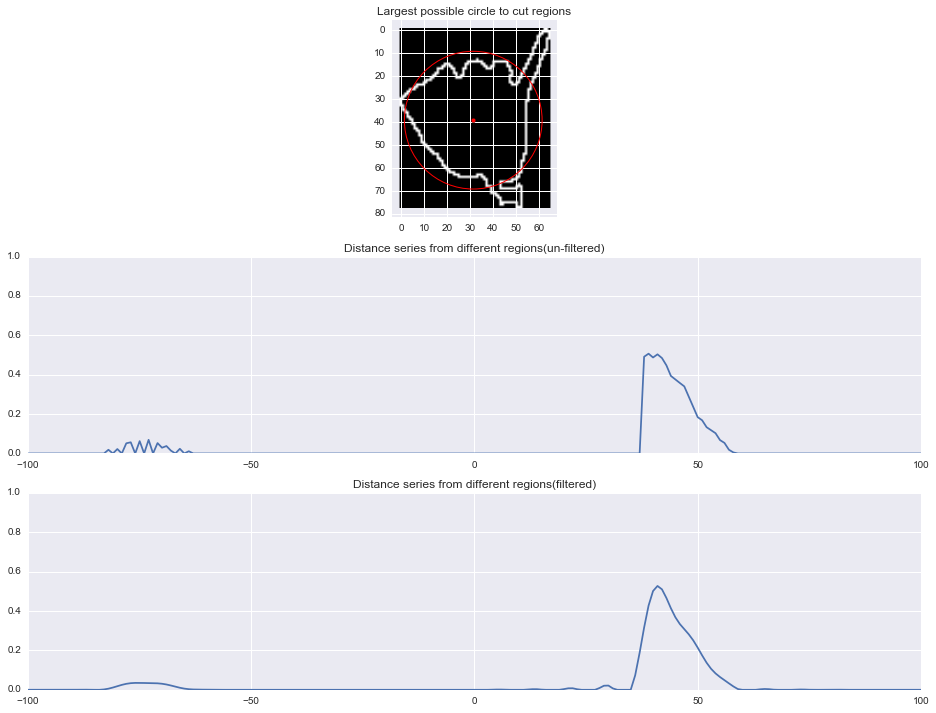

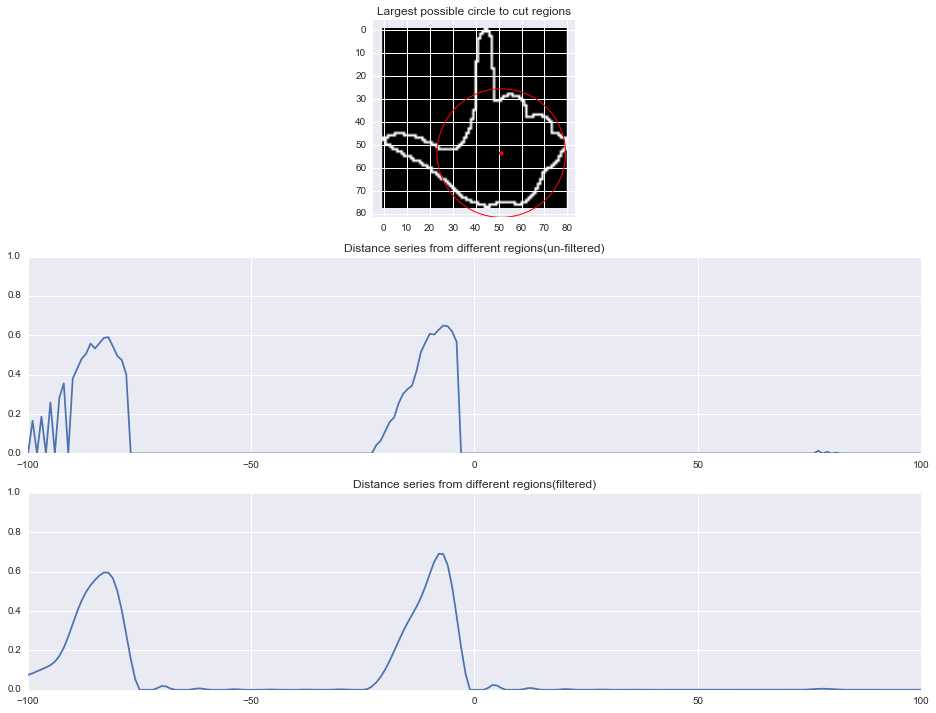

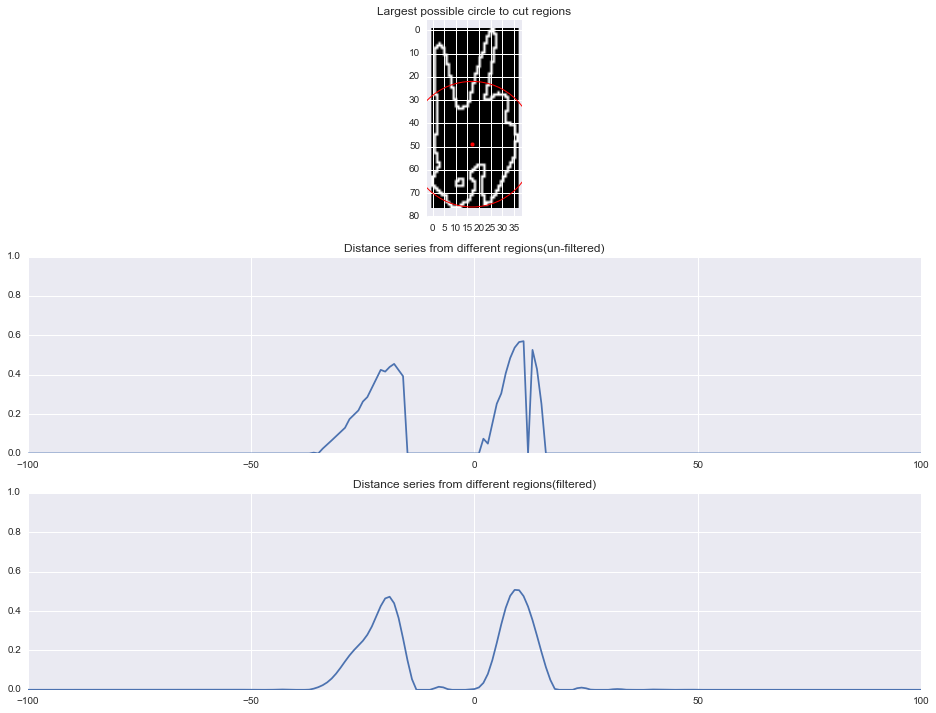

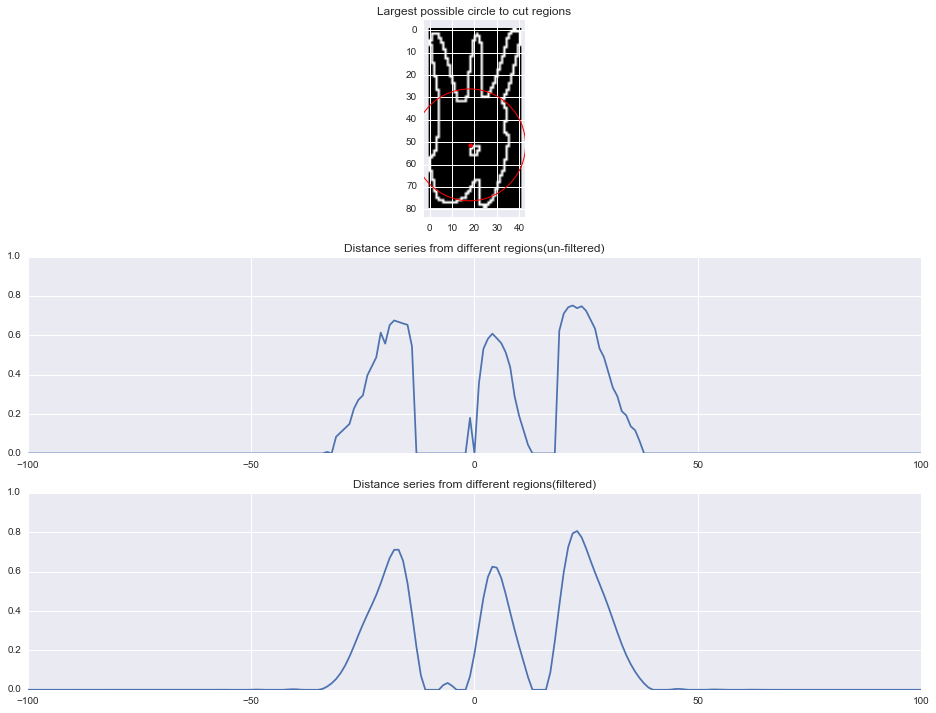

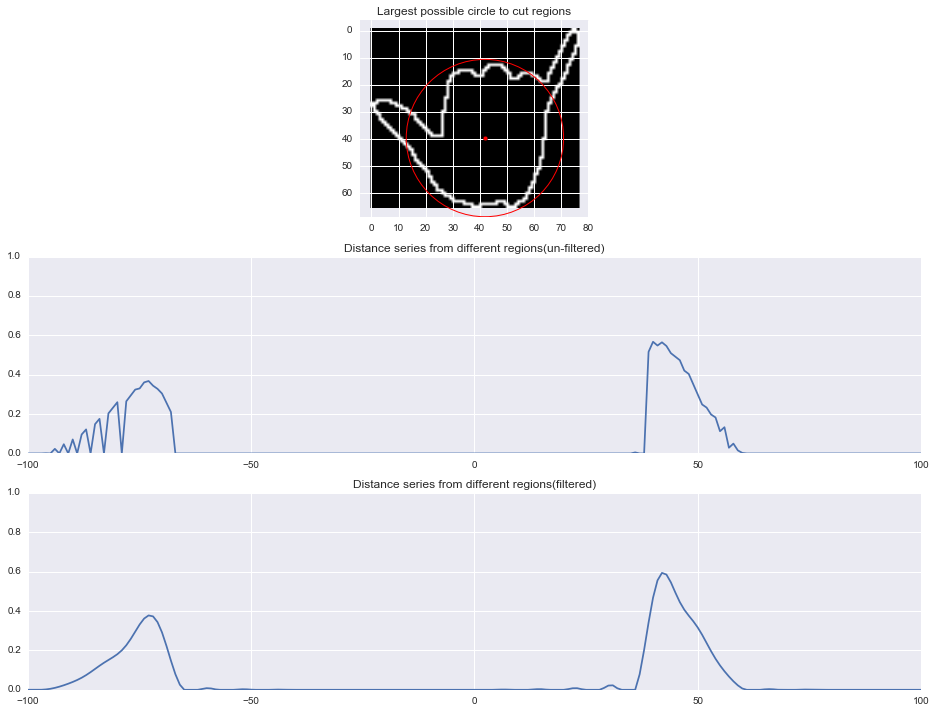

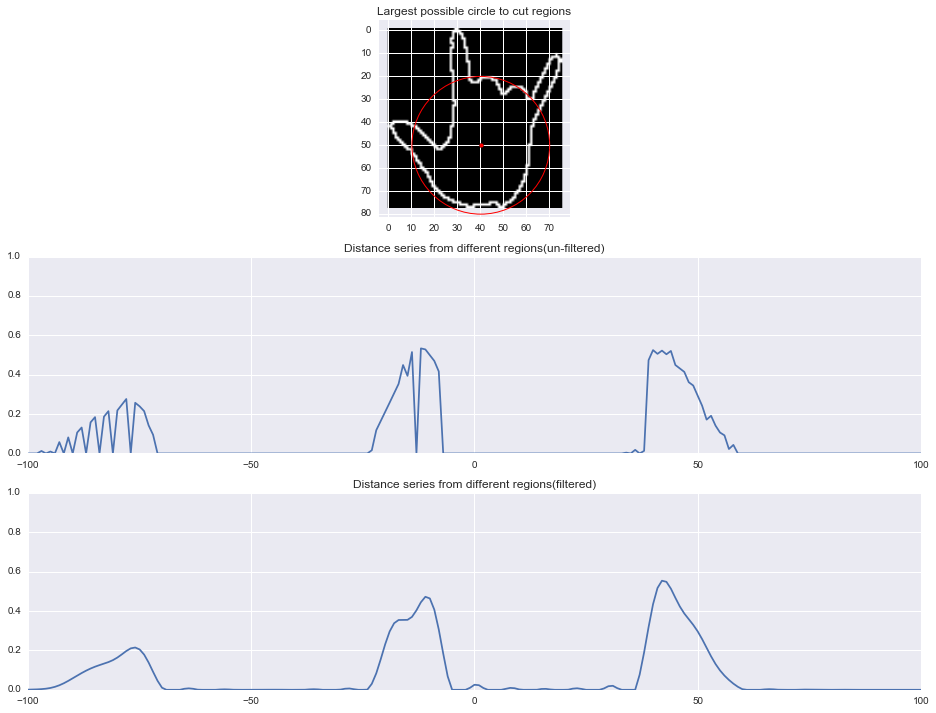

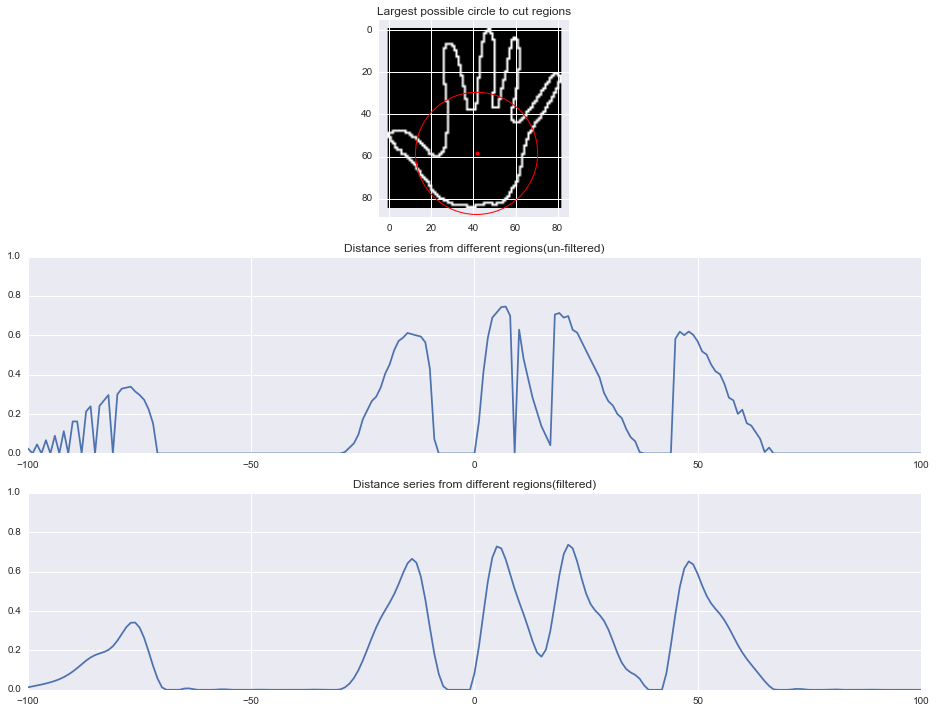

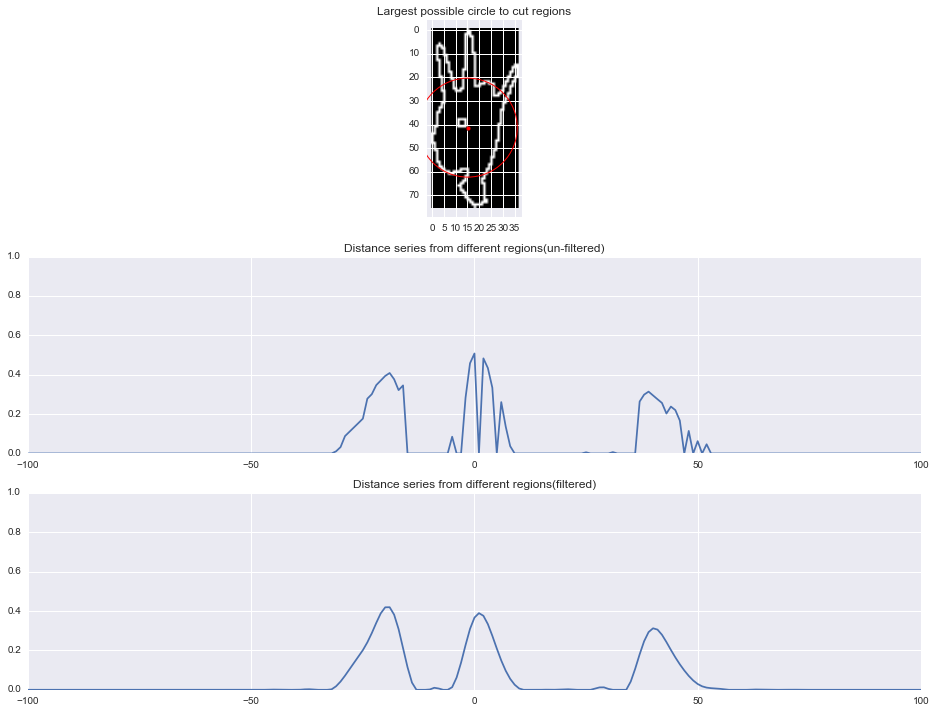

In [3]:
gesture_sdists = []
for i in range(1, 11):
    print('Processing frame_{}.png'.format(i))
    img = Image.open("LP_data/frame_{}.png".format(i))
    pixels = get_pixels(img)
    edge_pixels = find_edge_of_img(pixels)
    center, r = find_largest_circle(pixels)
    dists = get_dists(edge_pixels, center, r, vmax=40)
    sdists = smooth_dists(dists)
    gesture_sdists.append(sdists[80:280])

    plot_dists(edge_pixels, center, r, dists, sdists, xlim=(-100, 100))
plt.show()

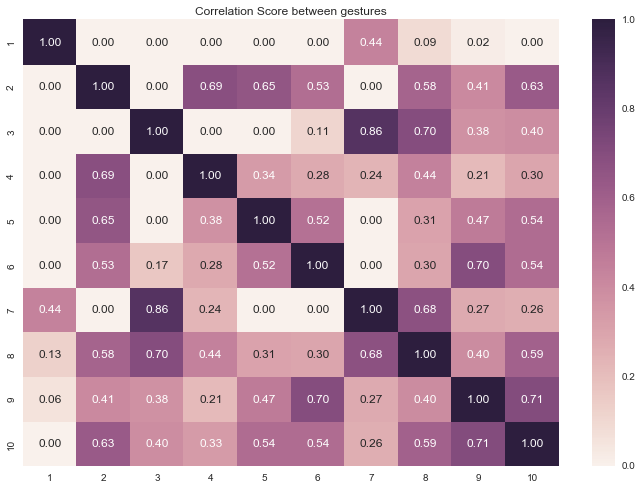

In [4]:
gesture_sdists = np.array(gesture_sdists)
gs = gesture_sdists
m = gs.shape[0]

corrs = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        corr = 0
        for k in range(-10, 10):
            roll_sdists = np.roll(gs[j], k)
            tcorr = correlation(gs[i], roll_sdists)
            if tcorr > corr:
                corr = tcorr
        corrs[i][j] = corr

plt.figure(figsize=(12, 8))
sns.heatmap(corrs, annot=True, fmt='.2f', xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.title('Correlation Score between gestures')
plt.show()

Best gesture: G2, Best Fitted Corr [ 0.96850484], Real Fitted Corr [ 0.96850484]
Best Fitted shift: 3, Real Fitted shift: 3


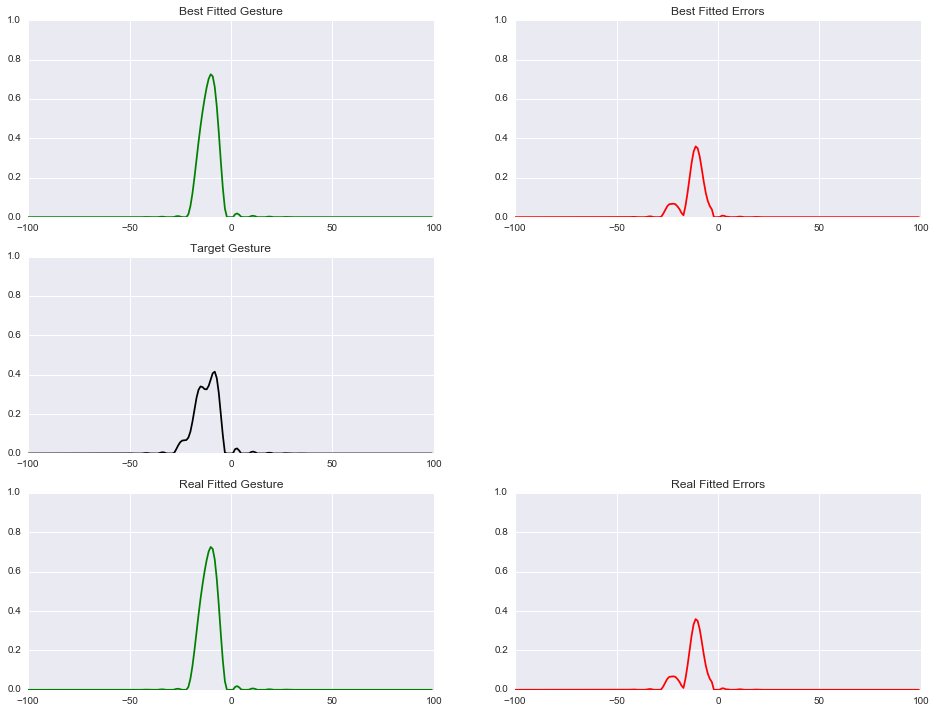

In [5]:
g = 2
f = 3
path = 'LP_data/frames/P1/G{}/frame_{}.png'.format(g, f)
img = Image.open(path)
pixels = get_pixels(img)
edge_pixels = find_edge_of_img(pixels)
center, r = find_largest_circle(pixels)
dists = get_dists(edge_pixels, center, r, vmax=40)
sdists = smooth_dists(dists)

best_corr = 0
best_gesture = -1
best_shift = 0
real_best_shift = 0
real_best_corr = 0

for t in range(10):
    for k in range(-20, 20):
        roll_sdists = np.roll(gs[t], k)
        corr = correlation(sdists[80:280], roll_sdists)
        if corr > real_best_corr and t == g-1:
            real_best_corr = corr
            real_best_shift = k
        if corr > best_corr:
            best_corr = corr
            best_gesture = t
            best_shift = k
roll_sdists = np.roll(gs[best_gesture], best_shift)
diff = difference(sdists[80:280], roll_sdists)

roll_sdists = np.roll(gs[g-1], real_best_shift)
rdiff = difference(sdists[80:280], roll_sdists)
print('Best gesture: G{}, Best Fitted Corr {}, Real Fitted Corr {}'.format(best_gesture+1, best_corr, real_best_corr))
print('Best Fitted shift: {}, Real Fitted shift: {}'.format(best_shift, real_best_shift))
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(3, 2, 1)
ax.set_title('Best Fitted Gesture')
ax.plot(range(-100, 100), np.roll(gs[best_gesture], best_shift), c='green', label='Best Fitted')
ax.set_ylim(0, 1)
ax = fig.add_subplot(3, 2, 3)
ax.set_title('Target Gesture')
ax.plot(range(-100, 100), sdists[80:280], c='black', label='Target')
ax.set_ylim(0, 1)
ax = fig.add_subplot(3, 2, 5)
ax.set_title('Real Fitted Gesture')
ax.plot(range(-100, 100), np.roll(gs[g-1], real_best_shift), c='green', label='Real Fitted')
ax.set_ylim(0, 1)
ax = fig.add_subplot(3, 2, 2)
ax.set_title('Best Fitted Errors')
ax.plot(range(-100, 100), diff, c='red', label='Best Fitted errors')
ax.set_ylim(0, 1)
ax = fig.add_subplot(3, 2, 6)
ax.set_title('Real Fitted Errors')
ax.plot(range(-100, 100), rdiff, c='red', label='Real Fitted errors')
ax.set_ylim(0, 1)
plt.show()

In [6]:
pf = 'P1'

y1 = []
X1 = []
for g in range(1, 11):
    gf = 'G{}'.format(g)
    for k in range(1, 11):
        path = 'LP_data/frames/{}/{}/frame_{}.png'.format(pf, gf, k)
        print('Processing {}'.format(path))
        img = Image.open(path)
        try:
            pixels = get_pixels(img)
            edge_pixels = find_edge_of_img(pixels)
            center, r = find_largest_circle(pixels)
            dists = get_dists(edge_pixels, center, r, vmax=40)
            sdists = smooth_dists(dists)
        except Exception as e:
            raise e
        y1.append(g)
        X1.append(sdists[80:280])

Processing LP_data/frames/P1/G1/frame_1.png
Processing LP_data/frames/P1/G1/frame_2.png
Processing LP_data/frames/P1/G1/frame_3.png
Processing LP_data/frames/P1/G1/frame_4.png
Processing LP_data/frames/P1/G1/frame_5.png
Processing LP_data/frames/P1/G1/frame_6.png
Processing LP_data/frames/P1/G1/frame_7.png
Processing LP_data/frames/P1/G1/frame_8.png
Processing LP_data/frames/P1/G1/frame_9.png
Processing LP_data/frames/P1/G1/frame_10.png
Processing LP_data/frames/P1/G2/frame_1.png
Processing LP_data/frames/P1/G2/frame_2.png
Processing LP_data/frames/P1/G2/frame_3.png
Processing LP_data/frames/P1/G2/frame_4.png
Processing LP_data/frames/P1/G2/frame_5.png
Processing LP_data/frames/P1/G2/frame_6.png
Processing LP_data/frames/P1/G2/frame_7.png
Processing LP_data/frames/P1/G2/frame_8.png
Processing LP_data/frames/P1/G2/frame_9.png
Processing LP_data/frames/P1/G2/frame_10.png
Processing LP_data/frames/P1/G3/frame_1.png
Processing LP_data/frames/P1/G3/frame_2.png
Processing LP_data/frames/P1/G

In [7]:
h1 = []
for sdists in X1:
    best_corr = 0
    best_gesture = -1
    for t in range(10):
        for k in range(-20, 20):
            roll_sdists = np.roll(gs[t], k)
            corr = correlation(sdists, roll_sdists)
            if corr > best_corr:
                best_corr = corr
                best_gesture = t
    h1.append(best_gesture+1)
print('Accuracy: {:.2%}'.format(accuracy_score(h1, y1)))

Accuracy: 81.00%


In [11]:
pf = 'P1'
X2 = []
y2 = []
for g in range(1, 11):
    gf = 'G{}'.format(g)
    for k in range(1, 11):
        path = 'LP_data/dataset/{}/{}/R{}_l.png'.format(pf, gf, k)
        print('Processing {}'.format(path))
        img = Image.open(path)
        try:
            pixels = get_pixels(img)
            edge_pixels = find_edge_of_img(pixels)
            center, r = find_largest_circle(pixels)
            dists = get_dists(edge_pixels, center, r, vmax=40)
            sdists = smooth_dists(dists)
        except Exception as e:
            continue
        y2.append(g)
        X2.append(sdists[80:280])

Processing LP_data/dataset/P1/G1/R1_l.png
Processing LP_data/dataset/P1/G1/R2_l.png
Processing LP_data/dataset/P1/G1/R3_l.png
Processing LP_data/dataset/P1/G1/R4_l.png
Processing LP_data/dataset/P1/G1/R5_l.png
Processing LP_data/dataset/P1/G1/R6_l.png
Processing LP_data/dataset/P1/G1/R7_l.png
Processing LP_data/dataset/P1/G1/R8_l.png
Processing LP_data/dataset/P1/G1/R9_l.png
Processing LP_data/dataset/P1/G1/R10_l.png
Processing LP_data/dataset/P1/G2/R1_l.png
Processing LP_data/dataset/P1/G2/R2_l.png
Processing LP_data/dataset/P1/G2/R3_l.png
Processing LP_data/dataset/P1/G2/R4_l.png
Processing LP_data/dataset/P1/G2/R5_l.png
Processing LP_data/dataset/P1/G2/R6_l.png
Processing LP_data/dataset/P1/G2/R7_l.png
Processing LP_data/dataset/P1/G2/R8_l.png
Processing LP_data/dataset/P1/G2/R9_l.png
Processing LP_data/dataset/P1/G2/R10_l.png
Processing LP_data/dataset/P1/G3/R1_l.png
Processing LP_data/dataset/P1/G3/R2_l.png
Processing LP_data/dataset/P1/G3/R3_l.png
Processing LP_data/dataset/P1/G3

In [9]:
h2 = []
for sdists in X2:
    best_corr = 0
    best_gesture = -1
    for t in range(10):
        for k in range(-20, 20):
            roll_sdists = np.roll(gs[t], k)
            corr = correlation(sdists, roll_sdists)
            if corr > best_corr:
                best_corr = corr
                best_gesture = t
    h2.append(best_gesture+1)

print('Accuracy: {:.2%}'.format(accuracy_score(h2, y2)))

Accuracy: 71.00%
